# Variação do algoritmo KNN para recomendação de filmes, com base nas avaliações em comum dos usuários

In [2]:
import pandas as pd

movies = pd.read_csv('movies.csv', index_col='movieId')
ratings = pd.read_csv('ratings.csv')

## Dataset movies (filmes)

In [3]:
movies

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
...,...,...
193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
193585,Flint (2017),Drama


## Dataset ratings (avaliações)

In [4]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


# Checagem dos datasets

## Buscando valores nulos

In [5]:
movies.isnull().sum()

,0
title,0
genres,0


In [6]:
ratings.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0


## Distribuição das notas

In [7]:
ratings.rating.value_counts()

,count
rating,
4.0,26818
3.0,20047
5.0,13211
3.5,13136
4.5,8551
2.0,7551
2.5,5550
1.0,2811
1.5,1791


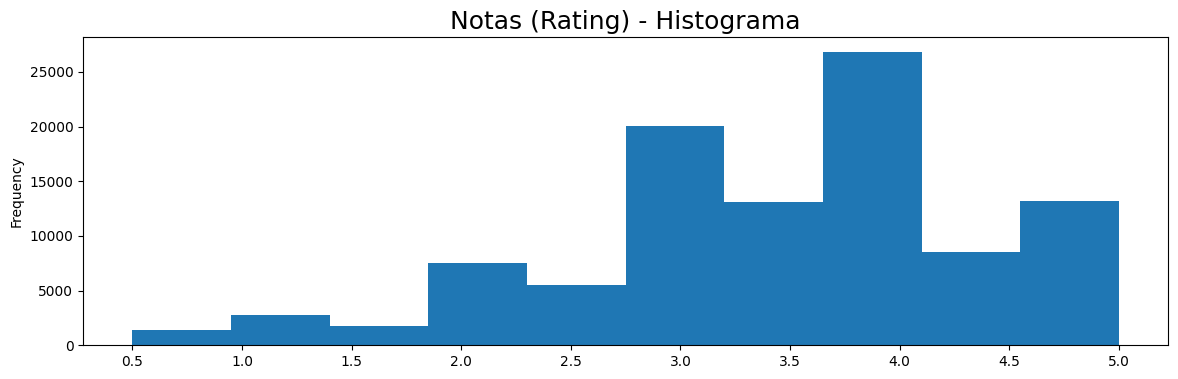

In [55]:
ax = ratings.rating.plot.hist(
  figsize=(14, 4),
  xticks=ratings.rating.unique(),
  title='Notas (Rating) - Histograma',
)
ax.title.set_size(18)

In [9]:
ratings.rating.describe()

,rating
count,100836.000000
mean,3.501557
std,1.042529
min,0.500000
25%,3.000000
50%,3.500000
75%,4.000000
max,5.000000


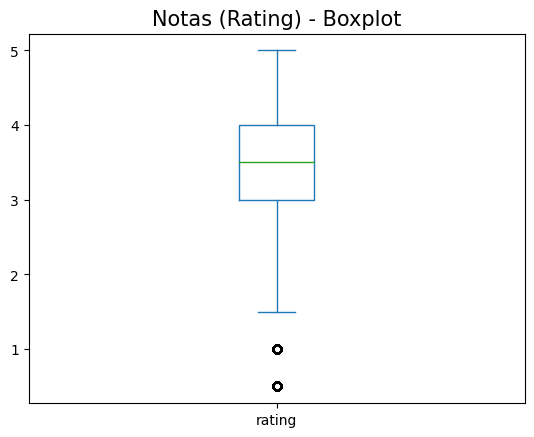

In [56]:
ax = ratings.rating.plot.box(title='Notas (Rating) - Boxplot')
ax.title.set_size(15)

- Notas variam de 0.5 a 5.0, a cada 0.5pts;
- Tendem a ser positivas: apenas 1/4 (25%) das notas estão abaixo de 3;
- 50% delas estão entre 3 e 4, sendo 4 a nota mais dada;
- Pelo boxplot, notas abaixo de 1.5 são atípicas (outliers).

# Conhecendo os filmes bem avaliados pelo nosso usuário exemplo, de id 8

In [61]:
USER_ID = 8

def userRatings(userId, ratings):
  userRatings = ratings[ratings.userId == userId][['movieId', 'rating']]
  userRatings = userRatings.set_index('movieId')
  return userRatings

allUserRatings = userRatings(USER_ID, ratings)
userRatedMovies = allUserRatings.join(movies).sort_values(['rating', 'title'], ascending=[False, True]).reset_index()
topUserRatedMovies = userRatedMovies.iloc[:15]
topUserRatedMovies

,movieId,rating,title,genres,ratings,average
0,34,5.0,Babe (1995),Children|Drama,128.0,3.65
1,590,5.0,Dances with Wolves (1990),Adventure|Drama|Western,164.0,3.84
2,357,5.0,Four Weddings and a Funeral (1994),Comedy|Romance,103.0,3.52
3,253,5.0,Interview with the Vampire: The Vampire Chroni...,Drama|Horror,109.0,3.46
4,364,5.0,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX,172.0,3.94
5,185,5.0,"Net, The (1995)",Action|Crime|Thriller,112.0,3.04
6,527,5.0,Schindler's List (1993),Drama|War,220.0,4.22
7,318,5.0,"Shawshank Redemption, The (1994)",Crime|Drama,317.0,4.43
8,380,5.0,True Lies (1994),Action|Adventure|Comedy|Romance|Thriller,178.0,3.50
9,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,204.0,4.24


In [74]:
def genresCount(movies):
  genres = movies.genres.str.get_dummies()
  countedGenres = genres.sum().sort_values(ascending=False)
  countedGenres = pd.DataFrame(countedGenres, columns=['count'])
  countedGenres['percentage (%)'] = (countedGenres['count'] / len(movies) * 100).round(2)
  countedGenres.loc['TOTAL MOVIES'] = [len(movies), 100]
  return countedGenres

topGenres = genresCount(topUserRatedMovies)
topGenres.style.set_table_attributes("style='display:inline'").set_caption(f'GÊNEROS PRESENTES NOS TOP 15 FILMES MAIS BEM AVALIADOS PELO USUÁRIO {USER_ID}')

print(f'''Obs: Um filme pode ter vários gêneros, influenciando na contagem de mais de um gênero abaixo.

GÊNEROS PRESENTES NOS TOP 15 FILMES MAIS BEM AVALIADOS PELO USUÁRIO {USER_ID}''')
topGenres

Obs: Um filme pode ter vários gêneros, influenciando na contagem de mais de um gênero abaixo.

GÊNEROS PRESENTES NOS TOP 15 FILMES MAIS BEM AVALIADOS PELO USUÁRIO 8


,count,percentage (%)
Drama,9,60.00
Adventure,5,33.33
Comedy,5,33.33
Thriller,5,33.33
Crime,4,26.67
Romance,3,20.00
Action,2,13.33
Children,2,13.33
IMAX,2,13.33
Animation,1,6.67


# 1ª forma de recomendação: Popularidade (total de votos)
## É uma das estratégias mais usadas de recomendação

In [13]:
movies['ratings'] = ratings.movieId.value_counts()
movies = movies.sort_values(['ratings', 'title'], ascending=[False, True])
movies.head(10).reset_index()

,movieId,title,genres,ratings
0,356,Forrest Gump (1994),Comedy|Drama|Romance|War,329.0
1,318,"Shawshank Redemption, The (1994)",Crime|Drama,317.0
2,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,307.0
3,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,279.0
4,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,278.0
5,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,251.0
6,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,238.0
7,110,Braveheart (1995),Action|Drama|War,237.0
8,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,224.0
9,527,Schindler's List (1993),Drama|War,220.0


# 2ª forma: Nota média
## O cuidado para que filmes com apenas uma avaliação nota 5 não apareçam no topo é não listar os filmes com menos de 'n' avaliações

In [14]:
movies['average'] = ratings.groupby('movieId').rating.mean().round(2)
movies = movies.sort_values(['average', 'ratings', 'title'], ascending=[False, False, True])
n = 30
moviesWithSeveralRatings = movies[movies.ratings >= n]
moviesWithSeveralRatings.head(10).reset_index()

,movieId,title,genres,ratings,average
0,318,"Shawshank Redemption, The (1994)",Crime|Drama,317.0,4.43
1,1204,Lawrence of Arabia (1962),Adventure|Drama|War,45.0,4.30
2,858,"Godfather, The (1972)",Crime|Drama,192.0,4.29
3,2959,Fight Club (1999),Action|Crime|Drama|Thriller,218.0,4.27
4,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,97.0,4.27
5,1276,Cool Hand Luke (1967),Drama,57.0,4.27
6,1221,"Godfather: Part II, The (1974)",Crime|Drama,129.0,4.26
7,904,Rear Window (1954),Mystery|Thriller,84.0,4.26
8,1213,Goodfellas (1990),Crime|Drama,126.0,4.25
9,48516,"Departed, The (2006)",Crime|Drama|Thriller,107.0,4.25


# 3ª forma: Distância entre usuários

## Comparando as avaliações do usuário 8 com as do usuário 1 por exemplo

In [15]:
def ratingsOfTwoUsers(userA, userB, ratings, how='inner'):
  ratingsUserA: pd.DataFrame = userRatings(userA, ratings)
  ratingsUserB: pd.DataFrame = userRatings(userB, ratings)
  ratingsOfTwoUsers_ = ratingsUserA.join(
    ratingsUserB,
    how=how,
    lsuffix='UserA',
    rsuffix='UserB',
  )
  return ratingsOfTwoUsers_


def differencesBetweenTwoUsers(userA, userB, ratings):
  ratingsTwoUsers = ratingsOfTwoUsers(userA, userB, ratings, how='outer')
  ratingsTwoUsers['difference'] = (ratingsTwoUsers.iloc[:, 0] - ratingsTwoUsers.iloc[:, 1]).abs()
  ratingsTwoUsers['score'] = ratingsTwoUsers['difference'] *-1 + 2
  ratingsTwoUsers['score'].fillna(-0.5, inplace=True)
  ratingsTwoUsers.sort_values(['score', 'ratingUserA'], ascending=False, inplace=True)
  return ratingsTwoUsers



print(f'''FAIXAS DE VALORES DAS COLUNAS ABAIXO:
- rating:     de 0.5 a 5.0
- difference: de 0.0 a 4.0
- score:      de -2.0 a +2.0

Obs: Se um usuário avaliou um filme (independente da nota) e o outro não, isso torna os usuários um pouco diferentes entre si.
Por isso colocaremos um score de -0.5 para essa diferença.


DIFERENÇAS DAS AVALIAÇÕES ENTRE OS USUÁRIOS {USER_ID} E 1''')
differencesBetweenTwoUsers(8, 1, ratings)

FAIXAS DE VALORES DAS COLUNAS ABAIXO:
- rating:     de 0.5 a 5.0
- difference: de 0.0 a 4.0
- score:      de -2.0 a +2.0

Obs: Se um usuário avaliou um filme (independente da nota) e o outro não, isso torna os usuários um pouco diferentes entre si.
Por isso colocaremos um score de -0.5 para essa diferença.


DIFERENÇAS DAS AVALIAÇÕES ENTRE OS USUÁRIOS 8 E 1


,ratingUserA,ratingUserB,difference,score
movieId,,,,
50,5.0,5.0,0.0,2.0
527,5.0,5.0,0.0,2.0
480,4.0,4.0,0.0,2.0
593,4.0,4.0,0.0,2.0
590,5.0,4.0,1.0,1.0
...,...,...,...,...
3744,NaN,4.0,NaN,-0.5
3793,NaN,5.0,NaN,-0.5
3809,NaN,4.0,NaN,-0.5


## Score de proximidade (ou distância) entre os usuários 8 e 1
### É a soma dos scores das avaliações acima

In [42]:
def proximityBetweenTwoUsers(userA, userB, ratings):
  differences = differencesBetweenTwoUsers(userA, userB, ratings)
  proximity = differences['score'].sum()
  return proximity

print(f'''Score de proximidade entre os usuários {USER_ID} e 1:
{proximityBetweenTwoUsers(8, 1, ratings)}
É negativo, então NÃO são semelhantes, são distantes''')

Score de proximidade entre os usuários 8 e 1:
-106.5
É negativo, então NÃO são semelhantes, são distantes


## Buscando os 'k' usuário mais próximos (semelhantes) ao usuário 8
### É com base no cálculo do score acima

In [43]:
# BUSCA OS K-NEAREST NEIGHBORS (KNN) (USUÁRIOS MAIS SEMELHANTES) DE ACORDO COM AS NOTAS QUE DERAM AOS FILMES
def knn(userId, ratings, k=10):
  # PARA NÃO DEMORAR COMPARANDO O USUÁRIO COM TODOS OS OUTROS DO SISTEMA, BASTA COMPARAR SÓ COM OS QUE AVALIARAM PELO MENOS ALGUM FILME EM COMUM
  allUserRatings = userRatings(userId, ratings)
  movies = allUserRatings.index.unique()
  moviesRatings = ratings[ratings.movieId.isin(movies)]
  users = moviesRatings[moviesRatings.userId != userId].userId.unique()

  proximities = [(u, proximityBetweenTwoUsers(userId, u, ratings)) for u in users]
  proximities = pd.DataFrame(proximities, columns=['user', 'score'])
  proximities = proximities.set_index('score')
  nearestNeighbors = proximities.sort_index(ascending=False).iloc[:k]
  return nearestNeighbors.user


print(f'USUÁRIOS MAIS SEMELHANTES AO USUÁRIO {USER_ID}')
knn(8, ratings).reset_index()

USUÁRIOS MAIS SEMELHANTES AO USUÁRIO 8


,score,user
0,33.5,446
1,21.0,347
2,19.5,94
3,18.5,512
4,15.0,455
5,14.5,321
6,14.5,566
7,14.5,38
8,13.5,404
9,13.5,379


## Recomendando filmes que, em média, foram bem avaliados pelos 'k' usuários mais próximos

In [18]:
def recommendationsFromKnn(userId, ratings, movies, nRecommendations=10, k=10):
  neighbors = knn(userId, ratings, k)
  ratingsIndexedByMovieId = ratings.set_index('movieId')
  neighborsRatings = [ratingsIndexedByMovieId[ratingsIndexedByMovieId.userId == neighbor].rating for neighbor in neighbors]
  neighborsRatings = pd.concat(neighborsRatings, axis=1)
  neighborsRatings = neighborsRatings.drop(ratings[ratings.userId == userId].movieId, errors='ignore')
  # SE UM "VIZINHO" NÃO AVALIOU UM FILME, PARA A MÉDIA CONSIDERAREMOS SUA NOTA COMO A MÉDIA DOS OUTROS VIZINHOS MENOS 0.5
  neighborsRatings = neighborsRatings.apply(lambda row: row.fillna(row.mean()-0.5), axis=1)

  neighborsAverage = neighborsRatings.mean(axis=1).round(2)
  neighborsAverage.name = 'neighborsAverage'
  neighborsAverage = movies.join(neighborsAverage, how='right')
  neighborsAverage = neighborsAverage.sort_values('neighborsAverage', ascending=False)
  neighborsAverage = neighborsAverage.reset_index()
  return neighborsAverage.iloc[:nRecommendations]


recommendationsFromKnn(USER_ID, ratings, movies)

,movieId,title,genres,ratings,average,neighborsAverage
0,246,Hoop Dreams (1994),Documentary,29.0,4.29,4.55
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215.0,3.92,4.55
2,802,Phenomenon (1996),Drama|Romance,46.0,3.34,4.55
3,223,Clerks (1994),Comedy,104.0,3.86,4.10
4,497,Much Ado About Nothing (1993),Comedy|Romance,43.0,3.81,3.98
5,151,Rob Roy (1995),Action|Drama|Romance|War,44.0,3.55,3.80
6,161,Crimson Tide (1995),Drama|Thriller|War,103.0,3.64,3.78
7,261,Little Women (1994),Drama,42.0,3.88,3.65
8,265,Like Water for Chocolate (Como agua para choco...,Drama|Fantasy|Romance,33.0,3.94,3.65
9,594,Snow White and the Seven Dwarfs (1937),Animation|Children|Drama|Fantasy|Musical,77.0,3.62,3.55


# === Testes ===

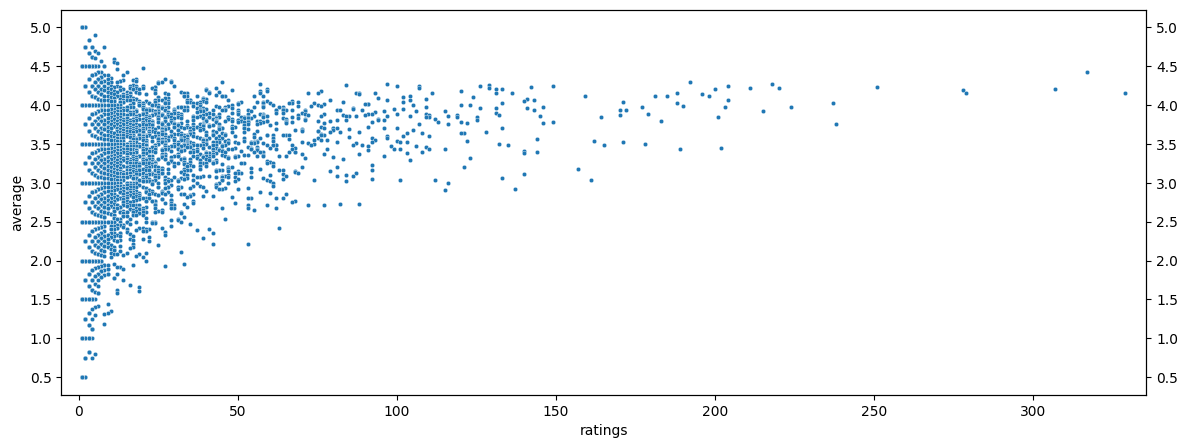

In [19]:
import seaborn as sns
from matplotlib.ticker import MaxNLocator

ax = sns.scatterplot(movies, x='ratings', y='average', s=10)
ax.figure.set_size_inches((14, 5))
ax.margins(x=0.02)

# AUMENTANDO A SEGMENTAÇÃO DO EIXO Y
nbins = 10
ax.yaxis.set_major_locator(MaxNLocator(nbins=nbins))

# DUPLICANDO O EIXO Y À DIREITA DO GRÁFICO
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.yaxis.set_major_locator(MaxNLocator(nbins=nbins))

In [20]:
ratingsMovie356 = ratings[ratings.movieId == 356].sort_values('timestamp') # Forrest Gump (1994)
ratingsMovie356.reset_index(drop=True, inplace=True)
ratingsMovie356.index += 1

ratingsMovie356['average_by_then'] = (ratingsMovie356.rating.cumsum() / ratingsMovie356.index).round(2)
ratingsMovie356

,userId,movieId,rating,timestamp,average_by_then
1,284,356,5.0,832695327,5.00
2,536,356,5.0,832840319,5.00
3,436,356,4.0,833530134,4.67
4,314,356,4.0,834241426,4.50
5,385,356,4.0,834691790,4.40
...,...,...,...,...,...
325,362,356,4.5,1530640048,4.16
326,98,356,5.0,1532457441,4.16
327,296,356,5.0,1532993877,4.17
328,514,356,4.0,1533871408,4.17


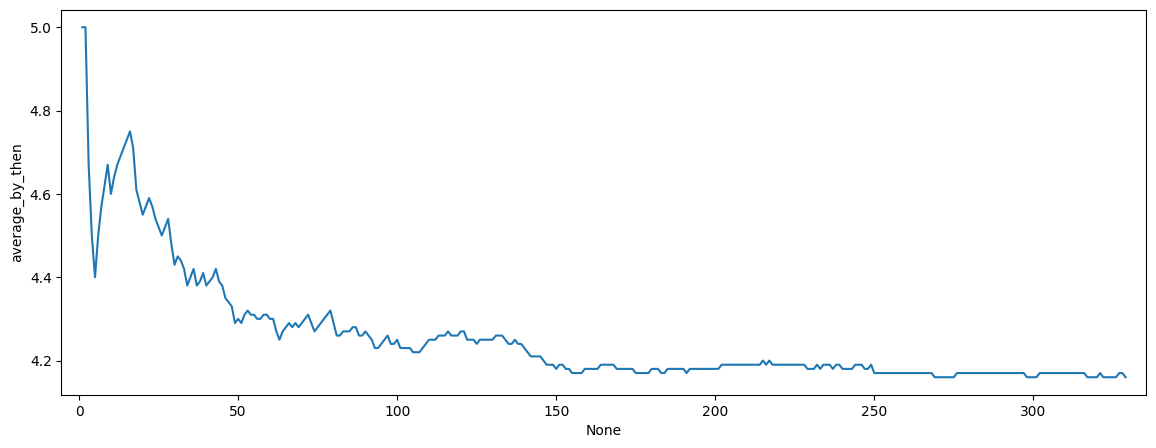

In [21]:
ax = sns.lineplot(ratingsMovie356, x=ratingsMovie356.index, y='average_by_then')
# ax = sns.scatterplot(ratingsMovie356, x=ratingsMovie356.index, y='rating', s=10, hue=1, palette=['orange'])
ax.figure.set_size_inches(14, 5)
ax.margins(x=0.02)

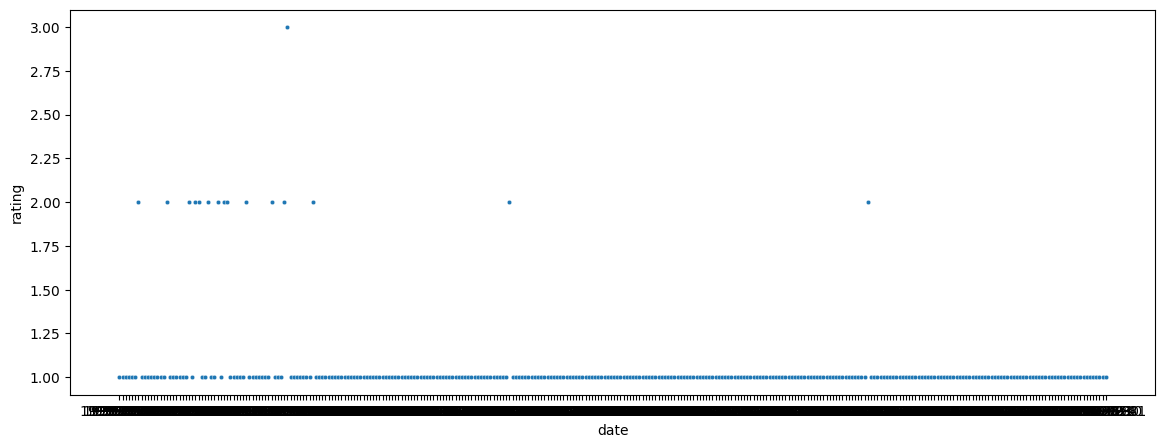

In [22]:
ratingsMovie356['date'] = pd.to_datetime(ratingsMovie356.timestamp, unit='s').dt.strftime('%Y-%m-%d')
ratingsMovie356ByDate = ratingsMovie356.groupby('date').rating.count()
ax = sns.scatterplot(x=ratingsMovie356ByDate.index, y=ratingsMovie356ByDate, s=10)
ax.figure.set_size_inches(14, 5)

In [23]:
n = 20
d = {}
for i in range(1, n):
  d[i] = {j: proximityBetweenTwoUsers(i, j, ratings) for j in range(i+1, n+1)} # usar range(i+1, n+1) em vez de range(2, n+1) evitará processamento duplicado
df = pd.DataFrame(d)
df = df.combine_first(df.T)
df.max().max()
df[(df == -2.5).any()].index

Index([8, 14], dtype='int64')

In [24]:
5 - ratings.rating.std()*1.96

# Já na estatística Z (amostras >= 30 elementos):
# 95%: 1.96
# 90%: 1.645
# 99%:

2.9566426914411554

In [25]:
pd.Series([5, None, None]).mean()

5.0